In [ ]:
!pip install torchio
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
for i in range(343,346):
  print(i)

343
344
345


In [ ]:
import torch
import torchio as tio
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
import math

In [ ]:
a=[1,2,3]
a[0:None]

[1, 2, 3]

In [ ]:
for i in range(5):
  print(i)

0
1
2
3
4


In [ ]:
def get_affine(params,volume_size,same_sub=False):
  if len(params.shape) != 1:
    batchsize=params.size(0)
  else:
    batchsize=params.size=1
  transform_list=[]
  for i in range(batchsize):
    if batchsize != 1:
      param=params[i]
    else:
      param=params.flatten()
    if same_sub:
      scales=[1,1,1]
      degrees=param[0:3]
      translation=param[3:6]
    else:
      scales=param[0:3]
      degrees=[d*math.pi/180 for d in param[3:6]]
      translation=param[6:9]





    # Rotation matrix
    R_x = torch.tensor([[1, 0, 0, 0],
                                  [0, math.cos(degrees[0]), -math.sin(degrees[0]), 0],
                                  [0, math.sin(degrees[0]), math.cos(degrees[0]), 0],
                                  [0, 0, 0, 1],])

    R_y = torch.tensor([[math.cos(degrees[1]), 0, math.sin(degrees[1]), 0],
                                  [0, 1, 0, 0],
                                  [-math.sin(degrees[1]), 0, math.cos(degrees[1]),0],
                                  [0, 0, 0, 1],])

    R_z = torch.tensor([[math.cos(degrees[2]), -math.sin(degrees[2]), 0, 0],
                                  [math.sin(degrees[2]), math.cos(degrees[2]), 0, 0],
                                  [0, 0, 1, 0],
                                  [0, 0, 0, 1],])
    R = R_x@R_y@R_z

    # Translation matrix
    T = torch.tensor([[1, 0, 0, -translation[0]/(volume_size[0]/2)],
                                [0, 1, 0, -translation[1]/(volume_size[1]/2)],
                                [0, 0, 1, -translation[2]/(volume_size[2]/2)],
                                [0, 0, 0, 1],])
    T=T.float()





    # Scaling matrix
    S = torch.tensor([[1/scales[0], 0, 0, 0],
                                [0, 1/scales[1], 0, 0],
                                [0, 0, 1/scales[2], 0],
                                [0, 0, 0, 1],])
    S = S.float()
    transform=R@T@S
    transform_list.append(transform[0:3])
  transform = torch.stack(transform_list)
  return transform

param tensor([  1.0000,   1.0000,   1.0000,   0.0000,   0.0000,   0.0000,  10.5186,
          6.9492, -19.9419])
size torch.Size([1, 1, 182, 182])


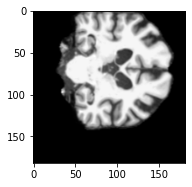

translation_tio (-19.9419, 6.9492, 10.5186)


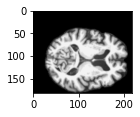

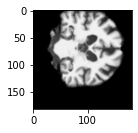

In [ ]:
# degrees = tuple(np.random.uniform(0, 2 * np.pi,size=3))
# scales = tuple(np.random.uniform(0.5, 1.5, size=3)) # eqaul to 1 if rigid
# translation = tuple(np.random.uniform(-5, 5, size=3))

# -38.0576, -19.9420,  -6.1096,  10.5186,   6.9492, -19.9419
degrees = torch.tensor([0,0,0])
scales = tuple([1,1,1]) # eqaul to 1 if rigid
translation = tuple([10.5186,6.9492,-19.9419])
param=torch.tensor([scales,degrees,translation]).view(1,9).squeeze(0)
print('param',param)
filename = "/content/ADNI_002_S_0295_MT1_N3m_m72_g_Normal_dx_1_age_91.0_scan0_mri_brainmask_mni152brain_affine_tl.nii"
img = nib.load(filename)
img = img.slicer[:,18:200,:]
volume_size=img.shape
data = img.get_fdata()
volume = torch.from_numpy(data)
volume=volume[None,None,:]
transform_inp=get_affine(param,volume_size)


transform_inp=transform_inp
grid = F.affine_grid(transform_inp, volume.size(), align_corners=True)
grid = grid.type_as(volume)
y = F.grid_sample(volume, grid, padding_mode='zeros', align_corners=True)
slice_index = y.size(-2) // 2
y_slice_1 = y[...,:,slice_index,:]
plt.subplot(1,2,1)
plt.imshow(y_slice_1[0,0,:,:], cmap='gray')
print("size",y_slice_1.shape)
plt.show()






translation_tio = tuple((list(translation))[::-1])
degrees_tio = tuple((list(degrees))[::-1])
scales_tio = tuple((list(scales))[::-1])

print("translation_tio",translation_tio)
affine_transform = tio.Affine(scales=scales_tio,degrees=degrees_tio,translation=translation_tio,center='image',default_pad_value='minimum')
resize = tio.Resize((182, 218, 182))
volume = tio.ScalarImage(filename)
subject = resize(tio.Subject(volume=volume))
volume_tensor = subject.volume.data
tranV = affine_transform(subject)
# take central slice,resize i
D = tranV.shape[3]
if D%2:
  central_crop = tio.Crop((0,0,0,0,D//2,D//2))
else:
  central_crop = tio.Crop((0,0,0,0,D//2,D//2-1))
central_slice = central_crop(tranV)
# pading by repeating
pad_trans = tio.Pad((0,0,0,0,0,D-1),padding_mode='edge')
PadV = pad_trans(central_slice)
# output 2D, 3D and parameters
input_volume = torch.cat((tranV.volume.data,PadV.volume.data),dim=0)
slice2D = central_slice.volume.data
plt.subplot(1,3,2)
plt.imshow(slice2D[0,:,:,0], cmap='gray')
plt.show()




volume_tio = tio.ScalarImage(filename)
subject = resize(tio.Subject(volume_tio=volume_tio))
volume_tensor = subject.volume_tio.data 
# img = nib.load(filename)
# img = img.slicer[:,18:200,:] # crop image so that each dimension have equal size
volume = volume_tensor
volume=volume[None,:]
volume=volume.double()
grid = F.affine_grid(transform_inp, volume.size(), align_corners=True)
grid = grid.type_as(volume)
y = F.grid_sample(volume, grid, padding_mode='zeros', align_corners=True)
slice_index = y.size(-2) // 2
y_slice_3 = y[...,:,slice_index,:].squeeze(0).squeeze(0) #[H,W]
plt.subplot(1,3,3)
plt.imshow(y_slice_3, cmap='gray')
plt.show()

In [ ]:
degrees = 90*(torch.rand(3)-0.5)
translation = 20*(torch.rand(3)-0.5)
param = torch.cat((degrees, translation), dim=0).squeeze(0)

In [ ]:
torch.pi

3.141592653589793

In [ ]:
image = torch.randn(1, 5, 5)

# Pad the image tensor with replication to create a 3D volume
padded_image = torch.nn.functional.pad(image, (0, 0, 1, 1, 1, 1), mode='replicate')

# Check the shape of the padded image
print(padded_image.shape)
# Output: torch.Size([3, 5, 5])

NotImplementedError: ignored

In [ ]:
import torch 
print(torch.__version__)

1.13.1+cu116


In [ ]:
degrees = 90*(torch.rand(3)-0.5)
translation = 20*(torch.rand(3)-0.5)
scales = (torch.rand(3)+1)/2 
a = torch.cat((scales, degrees, translation), dim=0)
a

tensor([  0.6693,   0.6968,   0.9900, -17.1609, -34.2911, -42.1437,   4.1730,
         -7.7688,   5.6672])

param tensor([  1.0000,   1.0000,   1.0000, -38.0576, -19.9420,  -6.1096,  10.5186,
          6.9492, -19.9419])


FileNotFoundError: ignored

In [ ]:
y_slice_3.shape

torch.Size([182, 218])

In [ ]:
y_slice_1[0,0,:,:].shape

torch.Size([182, 182])

In [ ]:
import torch.nn as nn
cre = nn.L1Loss()
cre(y_slice_3,y_slice_1[0,0,:,:])

tensor(8.6922, dtype=torch.float64)

In [ ]:

b = volume.data
b = b.double()
b.type()

'torch.DoubleTensor'

In [ ]:
central_slices=[]
y_slice = y_slice_1.squeeze(0).squeeze(0) #[H,W]
central_slices.append(y_slice)
central_slices.append(y_slice)
central_slices=torch.stack(central_slices,dim=0)
list(central_slices.shape) == [2,182,182]

True

In [ ]:
degrees = tuple([1,1,1])
scales = tuple([1,1,1]) # eqaul to 1 if rigid
translation = tuple([0,0,0])
param=torch.tensor([scales,degrees,translation]).view(1,9).squeeze(0)
param[3:6]

tensor([1, 1, 1])

size torch.Size([1, 1, 182, 218])


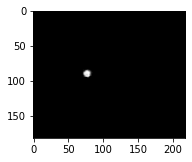

size torch.Size([1, 1, 182, 218])


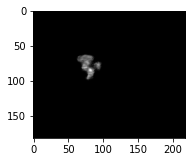

tensor([[ 0.6617, -0.6697,  1.1865, -0.0936],
        [ 0.8650, -0.7029, -0.7353,  0.3527],
        [ 0.4085,  0.9069,  0.3299,  0.7734]])

In [ ]:
affine = torch.tensor([degrees,scales,translation])
filename = "/content/ADNI_002_S_0295_MT1_N3m_m72_g_Normal_dx_1_age_91.0_scan0_mri_brainmask_mni152brain_affine_tl.nii"
img = nib.load(filename)
volume_size=img.shape
data = img.get_fdata()
volume = torch.from_numpy(data)
T_zero = np.array([[1, 0, 0, volume_size[0]/2],
                   [0, 1, 0, volume_size[1]/2],
                   [0, 0, 1, volume_size[2]/2],
                   [0, 0, 0, 1.],])

T_centre = np.array([[1, 0, 0, -volume_size[0]/2],
                     [0, 1, 0, -volume_size[1]/2],
                     [0, 0, 1, -volume_size[2]/2],
                     [0, 0, 0, 1.],])
matrix = torch.tensor([
        [1.6, 0.5, 0, 0.5],
        [0, 1, 0, 0.],
        [0, 0, 1, 0.],
        [0, 0, 0, 1.],
    ])
transform= T_zero.dot(matrix).dot(T_centre)
transform_inp=torch.tensor(transform[0:3])



volume=volume[None,None,:]
grid = F.affine_grid(transform_inp.unsqueeze(0), volume.size(), align_corners=True)
grid = grid.type_as(volume)
y = F.grid_sample(volume, grid, padding_mode='border', align_corners=True)

# Extract the central slice along the last dimension
slice_index = y.size(-1) // 2
y_slice_1 = y[...,:,slice_index]


matrix = torch.tensor([[ 0.6617, -0.6697,  1.1865, -0.0936],
          [ 0.8650, -0.7029, -0.7353,  0.3527],
          [ 0.4085,  0.9069,  0.3299,  0.7734]
    ])
grid = F.affine_grid(matrix.unsqueeze(0), volume.size(), align_corners=True)
grid = grid.type_as(volume)
y = F.grid_sample(volume, grid, padding_mode='border', align_corners=True)
slice_index = y.size(-1) // 2
y_slice_2 = y[...,:,slice_index]

plt.subplot(1,2,1)
plt.imshow(y_slice_1[0,0,:,:], cmap='gray')
print("size",y_slice_1.shape)
plt.show()

plt.subplot(1,2,2)
plt.imshow(y_slice_2[0,0,:,:], cmap='gray')
print("size",y_slice_2.shape)
plt.show()


matrix

In [ ]:
filename="/content/ADNI_002_S_0295_MT1_N3m_m72_g_Normal_dx_1_age_91.0_scan0_mri_brainmask_mni152brain_affine_tl.nii"
matrix_gt = torch.tensor([
        [1, 0, 0, 0.],
        [0, 1, 0, 0.],
        [0, 0, 1, 0.],
    ])
img = nib.load(filename)
data = img.get_fdata()
data = torch.from_numpy(data)
data=data[None,None,:]
data.shape
grid = F.affine_grid(matrix_gt.unsqueeze(0), data.size(), align_corners=True)
grid = grid.type_as(data)
y = F.grid_sample(data, grid, padding_mode='border', align_corners=True)

In [ ]:
b=y[0,0,100,:,:]
from PIL import Image
import torchvision
import torchvision.transforms as T
transform = T.ToPILImage()
img = transform(b)
img_r = img.resize((218,182))






In [ ]:
img_r.data

AttributeError: ignored

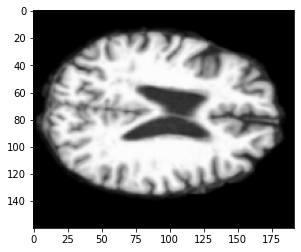

In [ ]:
import torch
matrix_pre = torch.tensor([
[1, 0, 0, 0.],
[0, 1, 0, 0.],
[0, 0, 1, 0.],])
b=[]
a = torch.tensor([1, 0, 0, 0.])
b.append(a)
b.append(a)
torch.stack(b)

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [ ]:
pre_param=[1,0,23]
para=pre_param[0]
matrix_pre = torch.tensor([
[para, 0, 0, 0.],
[0, 1, 0, 0.],
[0, 0, 1, 0.],])

matrix_gt = torch.tensor([
  [1, 0, 0, 0.],
  [0, 1, 0, 0.],
  [0, 0, 1, 0.],])